<div>NEDL</div>
<style>
  div {
    font-size: 36px;
    color: orange;
  }
</style>

<h3>BASIC</h3>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import coint
import statsmodels.api as sm
import scipy.optimize as spop

import os

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
df_closings = pd.DataFrame()
with os.scandir('raw_data/%s' % "Binance_Historical_1h_FUTURES_730_days_2022-06-16T08:05:42") as entries:
    for idx, entry in enumerate(entries):
      instrument = "_".join(entry.name.split("_")[0:2])
      df = pd.read_csv('raw_data/%s/%s' % ("Binance_Historical_1h_FUTURES_730_days_2022-06-16T08:05:42", entry.name), index_col="Date")
      df = df[["Close"]].copy()
      df.columns = [instrument]
      df_closings = pd.concat([df_closings, df], axis=1) 
      
# df_closings.fillna(method="ffill", inplace=True)
# df_closings.fillna(value=0, inplace=True)  

In [3]:
# low obs count outliers removal
df_observation_num = pd.DataFrame(columns=["observations"])
for column in df_closings.columns:
  df_observation_num.loc[column] = len(df_closings[column].dropna())

drop_columns = []
for idx, row in df_observation_num.iterrows():
  if row.observations < 2070: # arbitrarily selected value based on bottom values from df_observation_num
    drop_columns.append(row.name)
    
# removing outliers from the original DF
df_closings.drop(columns=drop_columns, inplace=True)

# cleaning DF
df_closings.dropna(inplace=True)
df_closings.shape

(2070, 146)

In [4]:
# final pair to test strategy
instruments = ['ETHUSDT_FUTURES', 'ETHBUSD_FUTURES']

In [5]:
# check more data can be loaded
entries = ["ETHUSDT_FUTURES_1h.csv", "ETHBUSD_FUTURES_1h.csv"]

df_closings = pd.DataFrame()

for idx, entry in enumerate(entries):
        # if entry.name.split("_")[0] in intersection:
      instrument = "_".join(entry.split("_")[0:2])
      df = pd.read_csv('raw_data/%s/%s' % ("Binance_Historical_1h_FUTURES_730_days_2022-06-16T08:05:42", entry), index_col="Date")
      df = df[["Close"]].copy()
      df.columns = [instrument]
      df_closings = pd.concat([df_closings, df], axis=1) 

# cleaning DF
df_closings.dropna(inplace=True)
df_closings.shape

(8766, 2)

In [19]:
df_closings

,HBARUSDT_FUTURES,ENJUSDT_FUTURES
Date,,
2021-03-17 07:00:00,0.33395,2.42764
2021-03-17 08:00:00,0.30397,2.37544
2021-03-17 09:00:00,0.30691,2.32785
2021-03-17 10:00:00,0.31083,2.37249
2021-03-17 11:00:00,0.30944,2.32551
...,...,...
2022-06-16 04:00:00,0.06995,0.46820
2022-06-16 05:00:00,0.06915,0.46360
2022-06-16 06:00:00,0.06861,0.46080


In [6]:
data = pd.DataFrame()
returns = pd.DataFrame()

for inst in instruments:
  data[inst] = df_closings[inst]
  returns[inst] = np.append(data[inst][1:].reset_index(drop=True)/data[inst][:-1].reset_index(drop=True) - 1 , 0)

In [7]:
int(len(data) * 0.1)

876

In [8]:
result = coint(returns[instruments[0]], returns[instruments[1]])
result

(-21.583590933787494, 0.0, array([-3.89768994, -3.33682719, -3.04493391]))

In [10]:
# init arrays
gross_returns = np.array([])
net_returns = np.array([])
t_s = np.array([])
inst1 = instruments[0]
inst2 = instruments[1]

window = int(len(data) * 0.1)
fee = 0.00025
t_threshold = -2.5

#moving through the sample
for t in range(window, len(data)):
    #defining the unit root function: stock2 = a + b*stock1
    def unit_root(b):
        a = np.average(data[inst2][t-window:t] - b*data[inst1][t-window:t])
        fair_value = a + b*data[inst1][t-window:t]
        diff = np.array(fair_value - data[inst2][t-window:t])
        diff_diff = diff[1:] - diff[:-1]
        reg = sm.OLS(diff_diff, diff[:-1])
        res = reg.fit()
        return res.params[0]/res.bse[0]
    #optimising the cointegration equation parameters
    res1 = spop.minimize(unit_root, data[inst2][t]/data[inst1][t], method='Nelder-Mead')
    t_opt = res1.fun
    b_opt = float(res1.x)
    a_opt = np.average(data[inst2][t-window:t] - b_opt*data[inst1][t-window:t])
    #simulating trading
    fair_value = a_opt + b_opt*data[inst1][t]
    if t == window:
        old_signal = 0
    # this can probably ommited initially
    if t_opt > t_threshold:
        signal = 0
        gross_return = 0
    else:
        signal = np.sign(fair_value - data[inst2][t])
        gross_return = signal*returns[inst2][t] - signal*returns[inst1][t]
    fees = fee*abs(signal - old_signal)
    net_return = gross_return - fees
    gross_returns = np.append(gross_returns, gross_return)
    net_returns = np.append(net_returns, net_return)
    t_s = np.append(t_s, t_opt)
    #interface: reporting daily positions and realised returns
    print('day '+str(data.index[t]))
    print('')
    if signal == 0:
        print('no trading')
    elif  signal == 1:
        print('long position on '+inst2+' and short position on '+inst1)
    else:
        print('long position on '+inst1+' and short position on '+inst2)
    print('gross daily return: '+str(round(gross_return*100,2))+'%')
    print('net daily return: '+str(round(net_return*100,2))+'%')
    print('cumulative net return so far: '+str(round(np.prod(1+net_returns)*100-100,2))+'%')
    print('')
    old_signal = signal
#plotting equity curves
plt.plot(np.append(1,np.cumprod(1+gross_returns)))
plt.plot(np.append(1,np.cumprod(1+net_returns)))

unit_root
[-0.65535324] [0.03166615]
unit_root
[-0.01391638] [0.00499388]
unit_root
[-0.01615136] [0.00521677]
unit_root
[-0.0296232] [0.00747383]
unit_root
[-0.0232273] [0.00686]
unit_root
[-0.0823186] [0.01291503]
unit_root
[-0.05626235] [0.01102921]
unit_root
[-0.25890979] [0.02231178]
unit_root
[-0.14765831] [0.0176592]
unit_root
[-0.56384111] [0.03013784]
unit_root
[-0.30892524] [0.02444851]
unit_root
[-0.71099456] [0.03217802]
unit_root
[-0.56384111] [0.03013784]
unit_root
[-0.71197734] [0.03224896]
unit_root
[-0.65347198] [0.03147138]
unit_root
[-0.71933978] [0.03229217]
unit_root
[-0.71197734] [0.03224896]
unit_root
[-0.71710433] [0.03225468]
unit_root
[-0.7176154] [0.03229043]
unit_root
[-0.71871474] [0.03227831]
unit_root
[-0.71897278] [0.03229622]
unit_root
[-0.71915104] [0.03228646]
unit_root
[-0.71928038] [0.03229542]
unit_root
[-0.7192764] [0.03228962]
unit_root
[-0.71934111] [0.0322941]
unit_root
[-0.71931584] [0.03229097]
day 2021-07-22 15:00:00

long position on ETHUSD

KeyboardInterrupt: 

<h3>ADVANCED</h3>

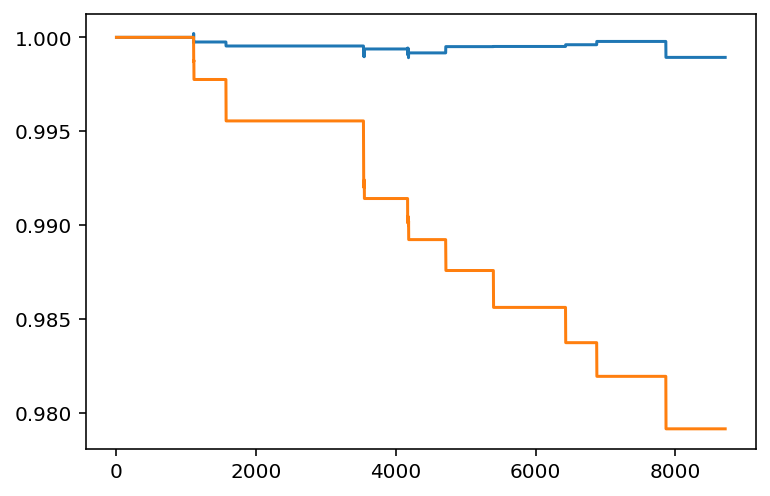

In [58]:
# RAW CODE COPY PASTED SO FAR
# NOT READY


#specifying rolling window length
window = 50
#specifying maximum KPSS statistic (95% critical value)
KPSS_max = 0.463
#specifying the KPSS test (one-parameter unbiased or two-parameter)
unbiased = 2
#specifying whether to perform beta-loading or not
beta_loading = 0
#strategy parameters - trading fee, optimal entry (divergence), and stop-loss
fee = 0.0005
entry = 0.03
stop_loss = -0.05
#initially start in cash
signal = 0
current_return = 0
position0 = 0
position1 = 0
#specifying the sample
start = df_closings.index[0]
end = df_closings.index[-1]
#specifying the pair
tickers = ['ETHUSDT_FUTURES', 'ETHBUSD_FUTURES']
#specifying the market index
# market = '^GSPC' # would spot be a good reference here?
#initialising arrays
gross_returns = np.array([])
net_returns = np.array([])
market_returns = np.array([])
signals = np.array([])
KPSS_stats = np.array([])
# raw_data = pd.DataFrame()
raw_data = df_closings
#downloading price data for stocks and the market index
# for ticker in tickers:
#     raw_data[ticker] = yf.download(ticker, start, end)['Close']
# raw_data['market'] = yf.download(market, start, end)['Close']
#moving in a loop through the sample
for t in range(window, len(raw_data)-1):
    old_signal = signal
    old_position0 = position0
    old_position1 = position1
    #specifying the subsample
    data = raw_data[t-window:t]
    #stock 2 = a + b*stock 1
    #OLS parameters as starting values
    reg = sm.OLS(np.array(data[tickers[1]]), sm.add_constant(np.array(data[tickers[0]])))
    res = reg.fit()
    a0 = res.params[0]
    b0 = res.params[1]
    if unbiased == 1:
        #defining the KPSS function (unbiased one-parameter forecast)
        def KPSS(b):
            a = np.average(data[tickers[1]] - b*data[tickers[0]])
            resid = np.array(data[tickers[1]] - (a + b*data[tickers[0]]))
            cum_resid = np.cumsum(resid)
            st_error = (np.sum(resid**2)/(len(resid)-2))**(1/2)
            KPSS = np.sum(cum_resid**2)/(len(resid)**2*st_error**2)
            return KPSS
        #minimising the KPSS function (maximising the stationarity)
        res = spop.minimize(KPSS, b0, method='Nelder-Mead')
        KPSS_opt = res.fun
        #retrieving optimal parameters
        b_opt = float(res.x)
        a_opt = np.average(data[tickers[1]] - b_opt*data[tickers[0]]) 
    else:
        #defining the KPSS function (two-parameter)
        def KPSS2(kpss_params):
            a = kpss_params[0]
            b = kpss_params[1]
            resid = np.array(data[tickers[1]] - (a + b*data[tickers[0]]))
            cum_resid = np.cumsum(resid)
            st_error = (np.sum(resid**2)/(len(resid)-2))**(1/2)
            KPSS = np.sum(cum_resid**2)/(len(resid)**2*st_error**2)
            return KPSS
        #minimising the KPSS function (maximising the stationarity)
        res = spop.minimize(KPSS2, [a0, b0], method='Nelder-Mead')
        #retrieving optimal parameters
        KPSS_opt = res.fun
        a_opt = res.x[0]
        b_opt = res.x[1]
    #simulate trading
    #first check whether stop-loss is violated
    if current_return < stop_loss:
        signal = 0
        print('stop-loss triggered')
    #if we are already in position, check whether the equilibrium is restored, continue in position if not
    elif np.sign(raw_data[tickers[1]][t] - (a_opt + b_opt*raw_data[tickers[0]][t])) == old_signal:
        singal = old_signal
    else:
        #only trade if the pair is cointegrated
        if KPSS_opt > KPSS_max:
            signal = 0
        #only trade if there are large enough profit opportunities (optimal entry)
        elif abs(raw_data[tickers[1]][t]/(a_opt + b_opt*raw_data[tickers[0]][t])-1) < entry:
            signal = 0
        else:
            signal = np.sign(raw_data[tickers[1]][t] - (a_opt + b_opt*raw_data[tickers[0]][t]))
    #calculate strategy returns with beta loading
    # if beta_loading == 1:
    #     rets0 = np.array(raw_data[tickers[0]][t-window:t-1])/np.array(raw_data[tickers[0]][t-window+1:t]) - 1
    #     rets1 = np.array(raw_data[tickers[1]][t-window:t-1])/np.array(raw_data[tickers[1]][t-window+1:t]) - 1
    #     rets_mkt = np.array(raw_data['market'][t-window:t-1])/np.array(raw_data['market'][t-window+1:t]) - 1
    #     reg = sm.OLS(rets0, sm.add_constant(rets_mkt))
    #     res = reg.fit()
    #     beta0 = res.params[1]
    #     reg = sm.OLS(rets1, sm.add_constant(rets_mkt))
    #     res = reg.fit()
    #     beta1 = res.params[1]
    #     position0 = beta1*signal
    #     position1 = -beta0*signal
    # #calculate strategy returns without beta loading
    # else:
    position0 = signal
    position1 = -signal
    #calculating returns
    gross = position0*(raw_data[tickers[0]][t+1]/raw_data[tickers[0]][t] - 1) + position1*(raw_data[tickers[1]][t+1]/raw_data[tickers[1]][t] - 1)
    net = gross - fee*(abs(position0 - old_position0) + abs(position1 - old_position1))
    # market = raw_data['market'][t+1]/raw_data['market'][t] - 1
    if signal == old_signal:
        current_return = (1+current_return)*(1+gross)-1
    else:
        current_return = gross
    #populating arrays
    KPSS_stats = np.append(KPSS_stats, KPSS_opt)
    signals = np.append(signals, signal)
    gross_returns = np.append(gross_returns, gross)
    net_returns = np.append(net_returns, net)
    # market_returns = np.append(market_returns, market)
#building the output dataframe
output = pd.DataFrame()
output['KPSS'] = KPSS_stats
output['signal'] = signals
output['gross'] = gross_returns
output['net'] = net_returns
# output['market'] = market_returns
#visualising the results
plt.plot(np.append(1,np.cumprod(1+gross_returns)))
plt.plot(np.append(1,np.cumprod(1+net_returns)))
# plt.plot(np.append(1,np.cumprod(1+market_returns)))

In [59]:
output

,KPSS,signal,gross,net
0,0.029690,0.0,-0.0,-0.0
1,0.049886,0.0,0.0,0.0
2,0.059798,0.0,0.0,0.0
3,0.032859,0.0,-0.0,-0.0
4,0.024625,0.0,0.0,0.0
...,...,...,...,...
8710,0.054269,0.0,-0.0,-0.0
8711,0.070998,0.0,-0.0,-0.0
8712,0.075042,0.0,-0.0,-0.0
8713,0.088431,0.0,-0.0,-0.0
